# Predicting the sale price of bulldozers using machine learning

In this notebook we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers


## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?


## 2. Data 

The data is downloaded from Kaggle's 'Blue Book For Bulldozers' competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

* Train.csv is the training set, which contains data through the end of 2011.

* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set     throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 -   November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of the project check: https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation 

**Note**: The goal for most regression models is to minimise error. For this project our goal is to build a machine learning model to  minimise the RMSLE.


## 4. Features

Kaggle provides a dictionary detailing all the features of the dataset. Here's the link to it: https://docs.google.com/spreadsheets/d/1iboG2DOOs2gaOKyBwpBg80QmywVZ9zSeQsYMdGFtT-o/edit?usp=sharing



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

C:\Users\Admin\ml_course\milestone_project_1\env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import the data
df = pd.read_csv('data/TrainAndValid.csv',
                 low_memory=False)               # Minimises the memory used when set to True

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
# Missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

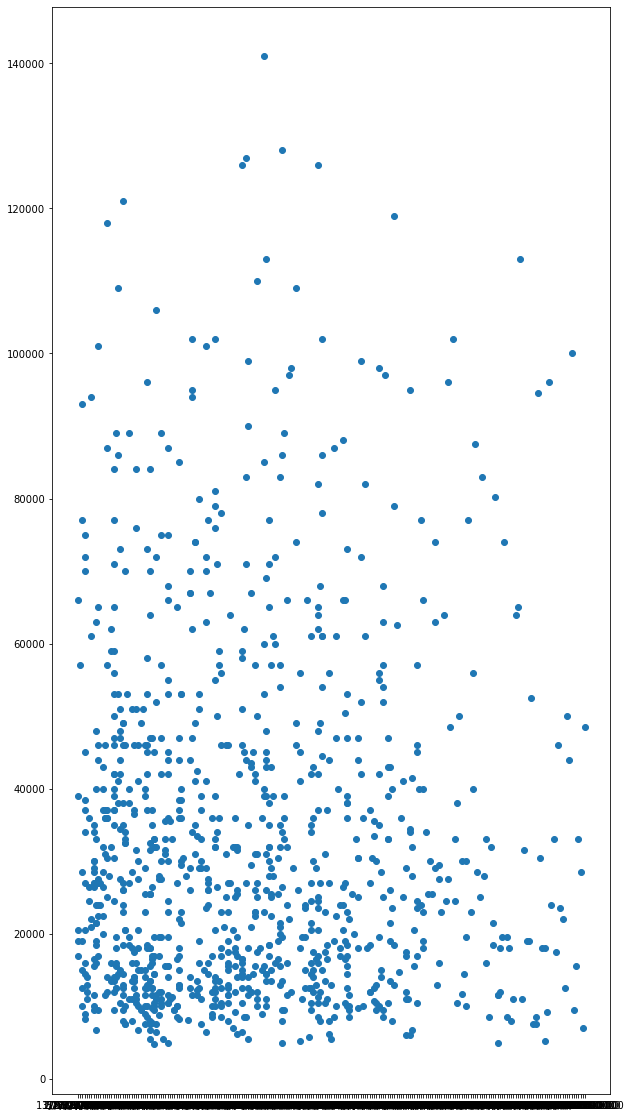

In [5]:
# Make some visualisations
fig, ax = plt.subplots(figsize=(10,20))
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

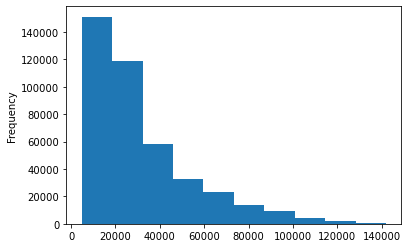

In [6]:
# A histogram now
df['SalePrice'].plot(kind='hist');

### Parsing Dates

When we work with time series data, we want to enrich the time and date component as much as possible.

We can do that by telling pandas which of our columns have dates in it using the `parse_dates` parameter.

In [66]:
# Import data again but this time with parsed dates
df = pd.read_csv('data/TrainAndValid.csv',
                 low_memory=False,
                 parse_dates=['saledate'])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate

# '<M8[ns]' is the same as datetime64[ns]

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

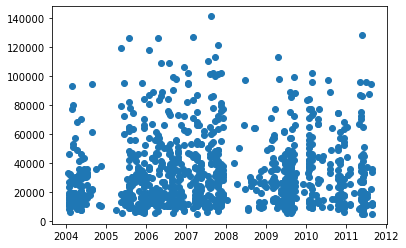

In [10]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);


### Sort the dataframe by saledate

When working with time series data, it is a good idea to sort dataframe by datetime

In [67]:
# Sort dataframe by date order
df.sort_values(by=['saledate'], inplace=True, ascending=True)

df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [68]:
df_tmp = df.copy()
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


### Add datetime parameters for `saledate` column

In [69]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayofWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayofYear'] = df_tmp.saledate.dt.dayofyear

In [14]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [70]:
# Now we've enriched our dataframe with datetime features we can remove saledate
df_tmp.drop('saledate', axis=1, inplace=True)

In [16]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've done enough EDA, lets start to do some model driven EDA.

In [17]:
# Lets build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=3)

model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

ValueError: could not convert string to float: 'Low'

In [18]:
df_tmp['UsageBand'].dtype

dtype('O')

In [71]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert data into category
One way we can convert our data into numbers is by converting into pandas categories

For reference: https://pandas.pydata.org/docs/reference/general_utility_functions.html#data-types-related-functionality

In [20]:

df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofWeek,saleDayofYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [72]:
pd.api.types.is_string_dtype(df_tmp['UsageBand'])

True

In [73]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
    

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [23]:
# This will turn all string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [24]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [25]:
# We see that all entries in the 'state'(for eg.) column have been ordered alphabetically
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [26]:
# Using cat.codes, we can also see what numeric values have been assigned to each entry
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas categories we now have a way to access all data in form of numbers

But we still have a bunch of missing data...


In [27]:
# Check missing data in form of percentage of missing values

df_tmp.isna().sum()/len(df_tmp)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

**Over 90% of missing data in some columns. Wow!**

### Save preprocessed data

In [74]:
# Export current tmp dataframe
df_tmp.to_csv('data/train_tmp.csv', index=False)

In [75]:
# Import preprocessed data
df_tmp = pd.read_csv('data/train_tmp.csv', low_memory=False)

In [30]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [76]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Fill missing values

### Fill numeric missing values first

In [77]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofWeek
saleDayofYear


In [33]:
# Check for which numerical values with null entries
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [78]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if data is missing or not
            df_tmp[label+'is_missing'] = pd.isnull(content)
            # Fill numeric value with median
            df_tmp[label].fillna(df_tmp[label].median(), inplace=True)

**Note**: We add the binary column because if we just fill out all missing data, there might have been a reason for the missing values in the first place. So, we keep a record of which columns had missing data

**Note**: We use `median()` instead of `mean()` because it is more robust.


In [35]:
# Demonstrate why median is more robust

hundreds = np.full((1000,), 100)

hundreds_billion = np.append(hundreds, 1000000000)

np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [79]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [37]:
# Check to see how many examples were missing
df_tmp.auctioneerIDis_missing.value_counts()

False    392562
True      20136
Name: auctioneerIDis_missing, dtype: int64

This corresponds with the number of missing values for auctioneerID we saw earlier

In [38]:
# WHat other values are to be filled?
df_tmp.isna().sum()

SalesID                                    0
SalePrice                                  0
MachineID                                  0
ModelID                                    0
datasource                                 0
auctioneerID                               0
YearMade                                   0
MachineHoursCurrentMeter                   0
UsageBand                             339028
fiModelDesc                                0
fiBaseModel                                0
fiSecondaryDesc                       140727
fiModelSeries                         354031
fiModelDescriptor                     337882
ProductSize                           216605
fiProductClassDesc                         0
state                                      0
ProductGroup                               0
ProductGroupDesc                           0
Drive_System                          305611
Enclosure                                334
Forks                                 214983
Pad_Type  

### Filling and turning categorical variables into number

In [39]:
# Check for columns that arent numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [80]:
# TUrn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column to indicate whether sample had missing values
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add plus 1
        df_tmp[label] = pd.Categorical(content).codes + 1

Here, `pandas.Categorical()` converts all entries in each column in a finite number of categories. (eg if the entries were a,b,c,d and e then the categorical values would be -1,0,1,2,3. A number for each distinct value). We use +1 because we want the values to begin from 0 and not -1

In [41]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [42]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [81]:
# Lets check if there are any missing values
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of our data is numeric and our df has no missing values, we should be able to build a machine learning model

In [44]:
%%time 

#Instantiate model
model =RandomForestRegressor(n_jobs=-1,
                             random_state=3)

# Fit the model
model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])


CPU times: total: 40min 42s
Wall time: 5min 21s


RandomForestRegressor(n_jobs=-1, random_state=3)

In [45]:
# Score the model
model.score(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

0.9875455761147198

**Question:** Why doesnt the above model hold water?

### Splitting data into train/validation sets

In [46]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [47]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [89]:
# Split data into train and validation set
df_val = df_tmp[df_tmp.saleYear==2012]
df_train = df_tmp[df_tmp.saleYear!=2021]

len(df_val), len(df_train)

(11573, 412698)

In [90]:
# SPlit into X and y 
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((412698, 102), (412698,), (11573, 102), (11573,))

### Building an evaluation function

In [91]:
# Create evaluation function. (The competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions 
    and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)  # If val score is greater, then the model is overfitting since we trained on X_train and X_val has very few rows
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Validation MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Validation RMSLE": rmsle(y_valid, val_preds),
              "Training R2": r2_score(y_train, train_preds),
              "Validation R2": r2_score(y_valid, val_preds)}
    return scores


## Testing our model on a subset (to tune the hyperparameters)

In [51]:
# # This takes too long... for experimentation

# %%time

# model = RandomForestRegressor(n_jobs=-1,
#                               random_state=42)

# model.fit(X_train, y_train)

In [52]:
# One solution, speed up the time by using fewer rows

# model.fit(X_train[:10000], y_train[:10000])

In [92]:
# Another is to change max_sample values
model = RandomForestRegressor(n_jobs=-1,
                              random_state=3,
                              max_samples=10000)

In [93]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: total: 1min 1s
Wall time: 8.45 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=3)

In [94]:
show_scores(model)

{'Training MAE': 5585.414215566831,
 'Validation MAE': 6696.931186554912,
 'Training RMSLE': 0.2578722286723328,
 'Validation RMSLE': 0.2771592690196329,
 'Training R2': 0.8609535198730391,
 'Validation R2': 0.853002854233629}

### Hyperparameter Tuning with `RandomisedSearchCV`

In [57]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {'n_estimators': np.arange(10,100,10),
           'max_depth': [None,3,5,10],
           'min_samples_split': np.arange(2,20,2),
           'min_samples_leaf': np.arange(1,20,2),
           'max_features': [0.5,1,'sqrt'],
           'max_samples': [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=3),
                              param_distributions=rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 45.5 s
Wall time: 1min 14s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=3),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [59]:
# Find the best hyperparameters for the model
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 10}

In [61]:
# Evalaute the randomised search model
show_scores(rs_model)

{'Training MAE': 7375.33150701098,
 'Validation MAE': 8391.954234023628,
 'Training RMSLE': 0.3244104013742621,
 'Validation RMSLE': 0.33811234805793794,
 'Training R2': 0.7712745016809305,
 'Validation R2': 0.7777620911282745}

**Note:** The validation RMSLE is worse because this model only trained on 10,000 samples of data

### Train a model with the best hyperparameters 

Note: These were found after 100 iterations of `RandomizedSearchCV`

In [97]:
%%time

# MOst ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=3)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 7min 50s
Wall time: 1min 6s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=3)

In [98]:
# Scores for ideal model
show_scores(ideal_model)

{'Training MAE': 2960.25962933129,
 'Validation MAE': 3444.1494043694306,
 'Training RMSLE': 0.14447500064711388,
 'Validation RMSLE': 0.14779679149834046,
 'Training R2': 0.9591011156500654,
 'Validation R2': 0.9588328565354748}

## Make predictions on test data

In [111]:
df_test = pd.read_csv('data/Test.csv',
                      low_memory=False,
                      parse_dates=['saledate'])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [100]:
# Make predictions on test dataset
test_preds = ideal_model.predict(df_test)

C:\Users\Admin\ml_course\milestone_project_1\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

### Preprocessing data (in other words, getting the test dataset in the same format as training dataset)

In [109]:
def preprocessed_data(df):
    """
    Performs transformations on the dataframe and then returns transformed dataframe
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayofWeek'] = df.saledate.dt.dayofweek
    df['saleDayofYear'] = df.saledate.dt.dayofyear
    
    df.drop('saledate', axis=1, inplace=True)
    
    # Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if data is missing or not
                df[label+'is_missing'] = pd.isnull(content)
                # Fill numeric value with median
                df[label].fillna(df[label].median(), inplace=True)

    # FIll categorical missing data and turn categorical data into numbers
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Add a binary column to indicate whether sample had missing values
            df[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add plus 1
            df[label] = pd.Categorical(content).codes + 1
            
    
    return df
    

In [112]:
# Use the preprocessor on df_test
df_test = preprocessed_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [116]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

C:\Users\Admin\ml_course\milestone_project_1\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- auctioneerIDis_missing

  warnings.warn(message, FutureWarning)


ValueError: X has 101 features, but RandomForestRegressor is expecting 102 features as input.

In [117]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerIDis_missing'}

In [118]:
# Manually adjust df_test to get 'auctioneerIDis_missing' column
df_test['auctioneerIDis_missing'] = False  # False because there's no missing value in auctioneerID in df_test.
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerIDis_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [119]:
# Now the columns match so we can try again to make predictions
test_preds = ideal_model.predict(df_test)

C:\Users\Admin\ml_course\milestone_project_1\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [120]:
test_preds


array([22214.7769457 , 19888.39794615, 46863.21366122, ...,
       13832.52774609, 16509.28666499, 27083.47605363])

We have some predictions but theyre not in Kaggle's preferred format:

https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

In [121]:
# Format the predictions into the same format Kaggle wants
df_preds = pd.DataFrame()

df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds

df_preds

,SalesID,SalesPrice
0,1227829,22214.776946
1,1227844,19888.397946
2,1227847,46863.213661
3,1227848,55410.386007
4,1227863,44518.074756
...,...,...
12452,6643171,46552.950538
12453,6643173,13324.252450
12454,6643184,13832.527746
12455,6643186,16509.286665


In [122]:
# Export predictions data
df_preds.to_csv('data/test_predictions.csv', index=False)

## Feature Importance

Feature Importance seeks to figure out which attributes of the data were most important in predicting the **target variable** (SalePrice)

In [123]:
# Find feature importances of our ideal model
ideal_model.feature_importances_

array([3.37747935e-02, 1.65671020e-02, 4.05882158e-02, 1.90349890e-03,
       3.28751668e-03, 2.08529043e-01, 3.04173681e-03, 9.84945988e-04,
       4.20843392e-02, 4.93685247e-02, 6.41188411e-02, 4.62837469e-03,
       2.23979305e-02, 1.43170410e-01, 4.48125808e-02, 6.01976886e-03,
       2.67182039e-03, 1.23000843e-03, 2.69649969e-03, 5.80082377e-02,
       6.74813012e-04, 3.41772582e-05, 1.30246713e-03, 2.15019776e-04,
       1.05744646e-03, 2.14173347e-05, 2.66069606e-03, 8.87202515e-03,
       2.42599394e-03, 1.10513315e-04, 1.87695112e-03, 7.20552501e-03,
       2.30083912e-03, 1.41024242e-03, 1.24388915e-03, 1.21711801e-02,
       9.32957478e-04, 1.13945049e-02, 1.66995689e-03, 1.72452535e-03,
       1.21703998e-03, 8.80817855e-04, 2.29766720e-03, 5.80078968e-04,
       4.16463845e-04, 3.16960779e-04, 2.24985722e-04, 2.20754734e-03,
       8.03680502e-04, 2.72998002e-04, 1.06060576e-03, 7.22143722e-02,
       3.77232648e-03, 5.65992658e-03, 2.83826902e-03, 9.93097618e-03,
      

In [163]:
# Helper function to plot and visualise it

def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns, 'feature_importances':importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))
    
    # Plot dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importances')
    ax.invert_yaxis();

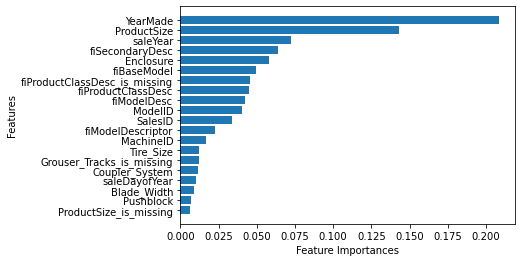

In [164]:
# PLot the features
plot_features(df_test.columns, ideal_model.feature_importances_)

# RESULT: The best model parameters gave a regression coefficient of 0.959

 * 'Training MAE': 2960.25962933129,
 * 'Validation MAE': 3444.1494043694306,
 * 'Training RMSLE': 0.14447500064711388,
 * 'Validation RMSLE': 0.14779679149834046,
 * 'Training R2': 0.9591011156500654,
 * 'Validation R2': 0.9588328565354748